
🔜 posterior_sampler.py: Sample N functions from posterior


In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import logging

import gpytorch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.constraints import GreaterThan


from time_series_generator import SyntheticTimeSeriesGenerator
#from time_series_dataset import TimeSeriesDataset


from gp_kernel_factory import KernelBuilder

from curriculum_selector import CurriculumSelector


from exact_gp_model import ExactGPModel


from exact_gp_trainer import ExactGPTrainer
from frozen_kernel_predictor import FrozenKernelPredictor
#from decomposition import GPDecomposer

import matplotlib.pyplot as plt


# prod

In [2]:
# Generate 10 synthetic time series (some low signal)
generator = SyntheticTimeSeriesGenerator(
    num_series=1000,
    series_length=500,
    trend_types=["long_term", "short_term", "seasonal"],
    noise_level=0.1,
    min_value=0.0,
    low_signal_ratio=0.01,
    low_signal_scale=0.1,
    seed=42
)
df = generator.generate()


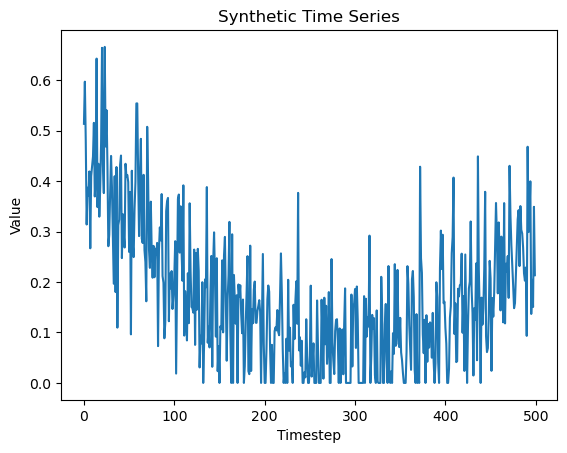

In [3]:
time_series_id = np.random.choice(df.series_id.unique(), 1)[0]
ts_df = df[df.series_id == time_series_id] # for testing
train_x = torch.tensor(ts_df["timestep"].values, dtype=torch.float32).unsqueeze(-1)  # shape [T, 1]
train_y = torch.tensor(ts_df["value"].values, dtype=torch.float32)  

plt.plot(ts_df["timestep"], ts_df["value"])
plt.title("Synthetic Time Series")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.show()

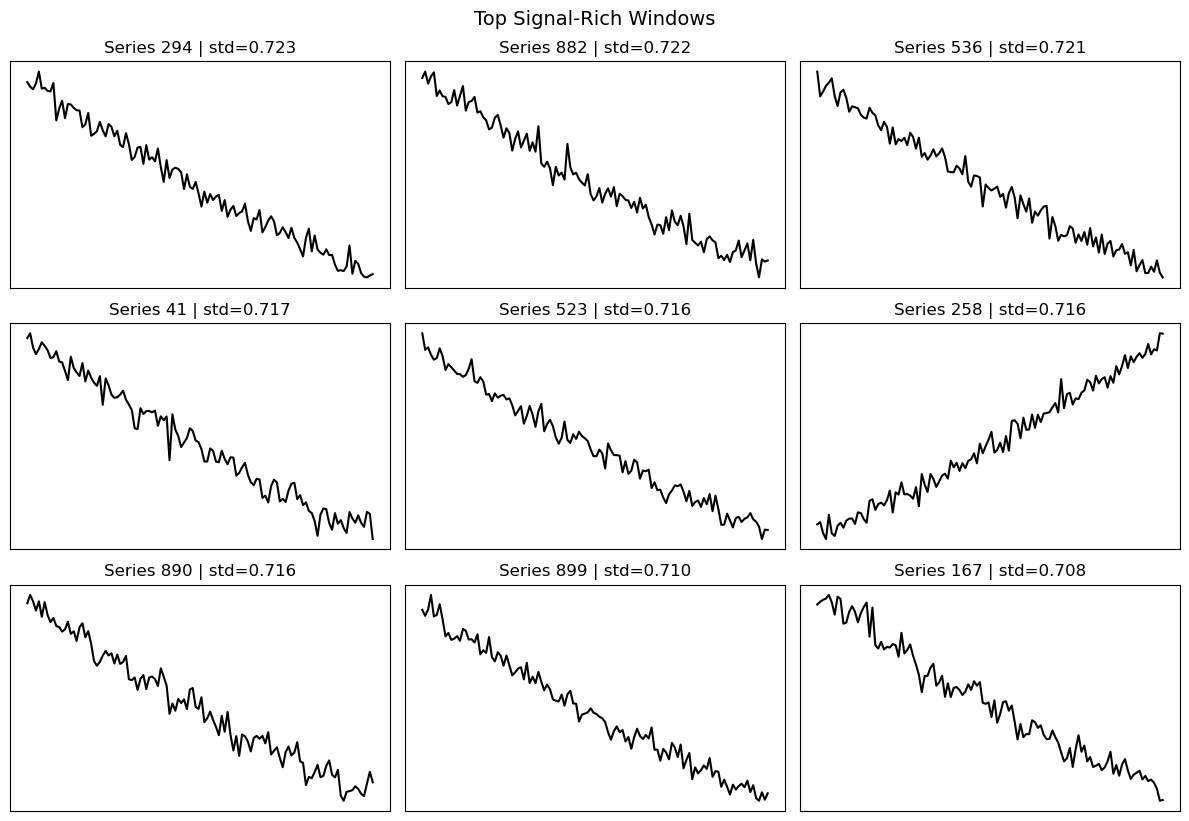

x_train shape: torch.Size([36000, 1])
y_train shape: torch.Size([36000])


In [4]:
selector = CurriculumSelector(df, window_length=120, stride=5, signal_metric="std", top_k=300)
selector.plot_sample_slices(num_samples=9)

x_list, y_list = selector.to_tensor_dataset()

x_train = torch.cat(x_list)
y_train = torch.cat(y_list)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

In [5]:
#kernel_config = {
#    "type": "RBF",
#    "lengthscale": 0.5
#}
#

In [6]:
kernel_config = {
    "type": "add",
    "components": [
        {
            "type": "scale",
            "outputscale": 1.0,
            "base_kernel": {
                "type": "RBF",
                "lengthscale": 1.0
            }
        },
        {
            "type": "scale",
            "outputscale": 0.5,
            "base_kernel": {
                "type": "Matern",
                "nu": 1.5,
                "lengthscale": 0.2
            }
        }
    ]
}


In [7]:
# kernel_config = {
#     "type": "add",
#     "components": [
#         {
#             "type": "scale",
#             "outputscale": 1.0,
#             "base_kernel": {
#                 "type": "RBF",
#                 "lengthscale": 100.0
#             }
#         },
#         {
#             "type": "scale",
#             "outputscale": 0.6,
#             "base_kernel": {
#                 "type": "Matern",
#                 "nu": 2.5,
#                 "lengthscale": 10.0
#             }
#         },
#         {
#             "type": "scale",
#             "outputscale": 0.4,
#             "base_kernel": {
#                 "type": "Periodic",
#                 "lengthscale": 3.0,
#                 "period_length": 12.0
#             }
#         }
#     ]
# }


In [8]:
#kernel_config = {
#    "type": "add",
#    "components": [
#        {
#            "type": "scale",
#            "outputscale": 1.0,
#            "base_kernel": {
#                "type": "RBF",
#                "lengthscale": 100.0,
#                "lengthscale_prior": {"mean": 100.0, "stddev": 20.0}
#            }
#        },
#        {
#            "type": "scale",
#            "outputscale": 0.5,
#            "base_kernel": {
#                "type": "Matern",
#                "nu": 1.5,
#                "lengthscale": 10.0,
#                "lengthscale_prior": {"mean": 10.0, "stddev": 3.0}
#            }
#        },
#        {
#            "type": "scale",
#            "outputscale": 0.4,
#            "base_kernel": {
#                "type": "Periodic",
#                "lengthscale": 3.0,
#                "period_length": 12.0,
#                "period_length_prior": {"mean": 12.0, "stddev": 2.0}
#            }
#        }
#    ]
#}
#

In [9]:
# Instantiate and constrain
likelihood = GaussianLikelihood()
likelihood.noise = torch.tensor(1e-1)



In [10]:

model = ExactGPModel(
    train_x=train_x,
    train_y=train_y,
    likelihood=likelihood,
    kernel_config= kernel_config,
    use_mvp_kernel=False,
    mean_type="zero"
)


🔧 ExactGPModel configuration:
  • Mean       : ZeroMean
  • Kernel     : AdditiveKernel
    - Composite of : ['ScaleKernel', 'ScaleKernel']




In [11]:
KernelBuilder(kernel_config).log_kernel_structure()

AdditiveKernel
[Component 0]
  ScaleKernel
    RBFKernel
    lengthscale: 1.0000
  outputscale: 1.0000
[Component 1]
  ScaleKernel
    MaternKernel
    lengthscale: 0.2000
  outputscale: 0.5000


In [12]:
# set logging level to info
logging.basicConfig(level=logging.INFO)

print(f"Initial noise: {likelihood.noise.item():.4f}")

trainer = ExactGPTrainer(
    model=model,
    likelihood=likelihood,
    train_x=train_x,
    train_y=train_y,
    lr=0.003,
    max_grad_norm=1.0
)

trainer.train(num_epochs=1000)

print(f"Final noise: {likelihood.noise.item():.4f}")


Initial noise: 0.1000


/home/simon/anaconda3/envs/gpytorch_2025/lib/python3.9/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)
INFO:exact_gp_trainer:[Epoch 001] Loss: 1.083836
INFO:exact_gp_trainer:Noise: 0.0994311049580574
INFO:exact_gp_trainer:[Epoch 025] Loss: 1.047253
INFO:exact_gp_trainer:Noise: 0.08673392981290817
INFO:exact_gp_trainer:[Epoch 050] Loss: 1.008592
INFO:exact_gp_trainer:Noise: 0.07536697387695312
INFO:exact_gp_trainer:[Epoch 075] Loss: 0.969155
INFO:exact_gp_trainer:Noise: 0.06562536209821701
INFO:exact_gp_trainer:[Epoch 100] Loss: 0.928633
INFO:exact_gp_trainer:Noise: 0.057248204946517944
INFO:exact_gp_trainer:[Epoch 125] Loss: 0.886558
INFO:exact_gp_trainer:Noise: 0.050013184547424316
INFO:exact_gp_trainer:[Epoch 150] Loss: 0.842348
INFO:exact_gp_trainer:Noise: 0.04373158887028694
INFO:e

Final noise: 0.0035


x_infer shape: torch.Size([200, 1])
x_grid shape: torch.Size([1000, 1])


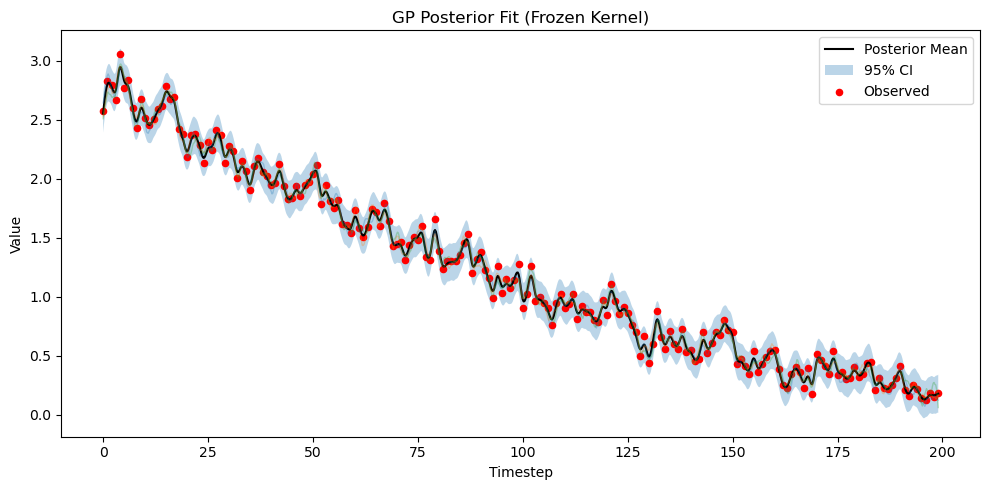

INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Derivatives] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[to_dataframe] adjust=True, derivatives=True


[Integrity Check]
Max abs diff: 0.07621
Mean abs diff: 0.01523
❌ Decomposition mismatch — investigate kernels or scaling ❌
[Derivative Consistency] Order=1 | Adjust=True
  Max abs diff : 0.157302
  Mean abs diff: 0.002402
❌ Derivative mismatch — investigate kernels or decomposition ❌


INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Derivatives] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Derivatives] Adjustment enabled (adjust=True)


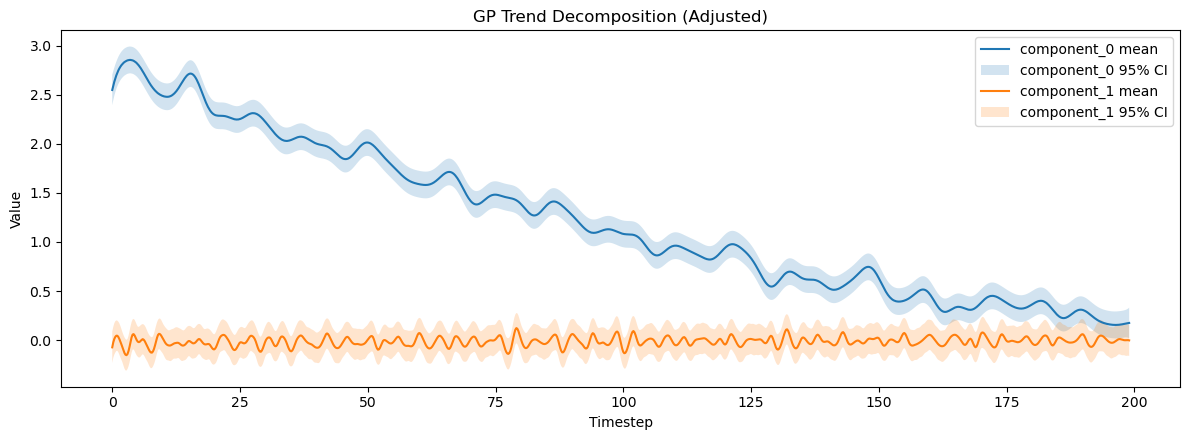

In [13]:
# === Select an unseen time series ===
ts_id = np.random.choice(df.series_id.unique())
ts_df_infer = df[df.series_id == ts_id].copy().iloc[:200]  # Optional slicing

x_infer = torch.tensor(ts_df_infer["timestep"].values, dtype=torch.float32).unsqueeze(-1)
y_infer = torch.tensor(ts_df_infer["value"].values, dtype=torch.float32)

# === Define predictor using frozen kernel & trained likelihood ===
#predictor = FrozenKernelPredictor(
#    kernel=model.covar_module,
#    likelihood=likelihood,  # reuse trained likelihood
#    component_names=["long_term", "short_term", "seasonal"]
#)


predictor = FrozenKernelPredictor(
    kernel=model.covar_module,
    likelihood=likelihood,  # reuse trained likelihood
    #component_names=["long_term", "short_term", "seasonal"]
)

predictor.infer(x_infer, y_infer)

# Optional: freeze for multiprocessing reuse
frozen_clone = predictor.freeze()

# === Evaluation grid
x_grid = torch.linspace(x_infer.min(), x_infer.max(), 1000).unsqueeze(-1)

# print the shape of the original x_infer
print(f"x_infer shape: {x_infer.shape}")

# print the shape of x_grid
print(f"x_grid shape: {x_grid.shape}")

# === Plot full fit with posterior samples ===
predictor.plot_fit(x_grid, show_samples=True, num_samples=3)

# === Decomposition (with adjusted components for interpretability) ===
decomp = predictor.posterior_decomposition(x_grid, adjust=True)

# ✅ Integrity check (after adjustment)
predictor.check_decomposition_integrity(x_grid, adjust=True)

# 
predictor.check_derivative_consistency(x_grid, adjust=True)



# === Plot each decomposed component ===
predictor.plot_decomposition(x_grid, num_samples=0, adjust=True)


In [14]:
df_trend = predictor.to_dataframe(x_grid, adjust=True, include_derivatives=True)
print(df_trend.shape)
df_trend.head(100)

INFO:frozen_kernel_predictor:[to_dataframe] adjust=True, derivatives=True
INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Derivatives] Adjustment enabled (adjust=True)
INFO:frozen_kernel_predictor:[Derivatives] Adjustment enabled (adjust=True)


(1000, 17)


,timestep,full_mean,full_lower,full_upper,full_d1,full_d2,component_0_mean,component_0_lower,component_0_upper,component_0_d1,component_0_d2,component_1_mean,component_1_lower,component_1_upper,component_1_d1,component_1_d2,observed
0,0.000000,2.552294,2.390417,2.714171,0.379408,-0.108821,2.550650,2.395280,2.706020,0.231960,-0.119325,-0.074567,-0.234296,0.085161,0.304749,0.208523,2.572456
1,0.199199,2.622554,2.464462,2.780646,0.327033,-0.255723,2.594440,2.445807,2.743072,0.208558,-0.115333,-0.023705,-0.181087,0.133677,0.208454,-0.403934,NaN
2,0.398398,2.682701,2.522495,2.842906,0.276308,-0.256357,2.633838,2.490035,2.777641,0.186100,-0.109927,0.010304,-0.149528,0.170136,0.139080,-0.302624,NaN
3,0.597598,2.732381,2.571865,2.892896,0.223776,-0.274222,2.668604,2.527626,2.809582,0.164837,-0.103343,0.032291,-0.127654,0.192237,0.083900,-0.263537,NaN
4,0.796797,2.771574,2.614742,2.928406,0.165892,-0.310189,2.699594,2.560381,2.838808,0.144990,-0.095956,0.044140,-0.112178,0.200457,0.030177,-0.284328,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,18.923923,2.346137,2.191607,2.500668,-0.115669,-0.116200,2.359953,2.223682,2.496223,-0.090086,0.060931,-0.041368,-0.195655,0.112920,-0.020413,-0.210959,NaN
96,19.123123,2.320484,2.165404,2.475564,-0.139670,-0.076603,2.343189,2.206855,2.479524,-0.077747,0.062645,-0.049859,-0.204634,0.104917,-0.064979,-0.160756,NaN
97,19.322323,2.291994,2.132876,2.451112,-0.143550,0.034631,2.329020,2.192645,2.465394,-0.065268,0.062170,-0.065105,-0.223859,0.093649,-0.081512,-0.012379,NaN
98,19.521523,2.264752,2.104135,2.425370,-0.126202,0.139846,2.317200,2.180933,2.453466,-0.053104,0.059656,-0.080770,-0.241094,0.079553,-0.071807,0.105746,NaN


Component columns: ['component_0_mean', 'component_1_mean']


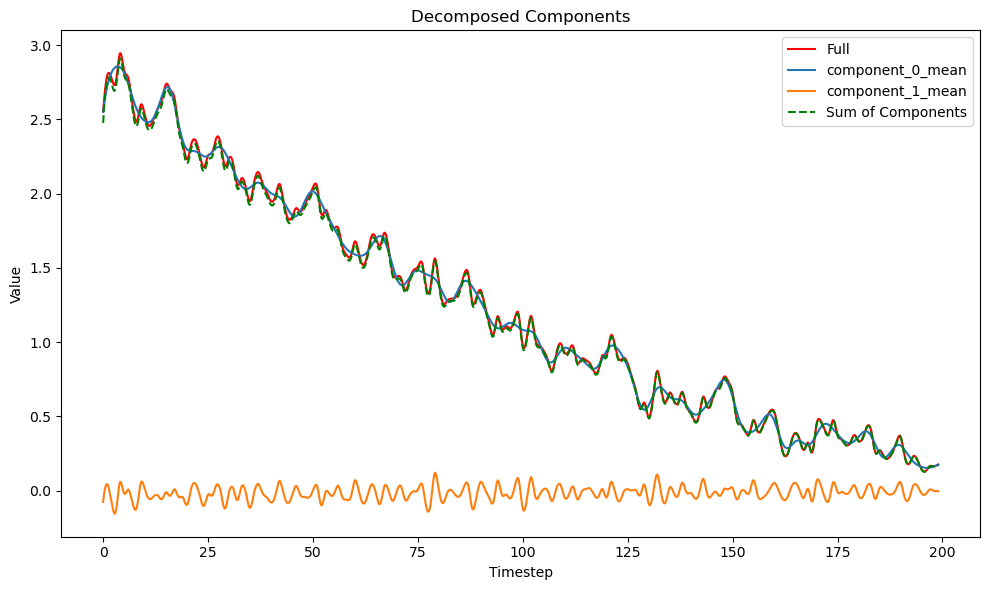

In [15]:


# Plot the full mean
plt.figure(figsize=(10, 6))
plt.plot(x_grid.numpy(), df_trend["full_mean"], label="Full", color='red')

# === Plot all components ===
# Find all mean component columns (excluding full)
component_cols = [col for col in df_trend.columns if col.endswith("_mean") and not col.startswith("full")]

# Debug print
print("Component columns:", component_cols)

# Plot each
for col in component_cols:
    plt.plot(x_grid.numpy(), df_trend[col], label=col)

# === Plot sum of all components ===
# Get all mean columns (excluding full) for summing
all_means = df_trend[component_cols].sum(axis=1)
plt.plot(x_grid.numpy(), all_means, label="Sum of Components", color='green', linestyle="--")

plt.legend()
plt.title("Decomposed Components")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


In [16]:
samples = predictor.sample_posterior(x_grid, num_samples=3)
samples

tensor([[2.5873, 2.6439, 2.6875,  ..., 0.1652, 0.1655, 0.1667],
        [2.5379, 2.6306, 2.6892,  ..., 0.1304, 0.1255, 0.1275],
        [2.5313, 2.6114, 2.6857,  ..., 0.1292, 0.1374, 0.1433]])

In [18]:
samples = predictor.sample_decomposition(x_grid, num_samples=20, adjust=True)
samples

INFO:frozen_kernel_predictor:[Decomposition] Adjustment enabled (adjust=True)


{'component_0': tensor([[2.5275, 2.5706, 2.5910,  ..., 0.1285, 0.1053, 0.1154],
         [2.5398, 2.5745, 2.6060,  ..., 0.0817, 0.0840, 0.0819],
         [2.5114, 2.5724, 2.5931,  ..., 0.1409, 0.1564, 0.2098],
         ...,
         [2.5562, 2.6141, 2.6678,  ..., 0.1004, 0.0963, 0.1081],
         [2.4480, 2.5437, 2.5818,  ..., 0.2444, 0.2157, 0.1900],
         [2.5966, 2.6550, 2.6648,  ..., 0.2078, 0.1875, 0.1784]]),
 'component_1': tensor([[-0.0807, -0.0235,  0.0134,  ...,  0.0121,  0.0342,  0.0286],
         [-0.0958, -0.0371,  0.0032,  ...,  0.0257, -0.0029, -0.0355],
         [-0.0440, -0.0353, -0.0344,  ...,  0.0164, -0.0057, -0.0238],
         ...,
         [-0.0127,  0.0325,  0.0625,  ...,  0.0093,  0.0413,  0.0468],
         [-0.0251,  0.0241,  0.0502,  ..., -0.0556, -0.0463, -0.0571],
         [-0.0847, -0.0252,  0.0103,  ..., -0.0350, -0.0194, -0.0167]])}

In [19]:
df_samples = predictor.sample_decomposition(x_grid, num_samples=50, return_dataframe=True)
df_samples.head()


INFO:frozen_kernel_predictor:[Decomposition] No adjustment (adjust=False)


,timestep,sample_id,component,value
0,0.0,0,component_0,2.438373
1,0.0,1,component_0,2.556830
2,0.0,2,component_0,2.507400
3,0.0,3,component_0,2.604041
4,0.0,4,component_0,2.615169
